## Mean Encoding or Target Encoding

Mean encoding implies replacing the category by the average target value for that category. For example, if we have the variable city, with categories London, Manchester and Bristol, and we want to predict the default rate, if the default rate for London is 30% we replace London by 0.3, if the default rate for Manchester is 20% we replace Manchester by 0.2 and so on.


## In this demo:

We will see how to perform one hot encoding with pandas using the Titanic dataset.

For guidelines to obtain the dataset, visit **section 2** of the course.

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [19]:
# load dataset

data = pd.read_csv(
    "../../Data/titanic.csv", usecols=["cabin", "sex", "embarked", "survived"]
)

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [20]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo
data["cabin"] = data["cabin"].astype(str).str[0]

In [21]:
# let's fill na
data.fillna("Missing", inplace=True)

In [22]:
# let's have a look at how many labels each variable has
for col in data.columns:
    print(f"{col}: {len(data[col].unique())} labels")

survived: 2 labels
sex: 2 labels
cabin: 9 labels
embarked: 4 labels


In [23]:
# let's explore the unique categories
data["cabin"].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'T', 'F', 'G'], dtype=object)

In [24]:
data["sex"].unique()

array(['female', 'male'], dtype=object)

In [25]:
data["embarked"].unique()

array(['S', 'C', 'Missing', 'Q'], dtype=object)

### Encoding important

We calculate the target mean per category using the train set, and then use those mappings in the test set.

In [26]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data[["cabin", "sex", "embarked"]],
    data["survived"],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 3), (393, 3))

### Explore original relationship between categorical variables and target

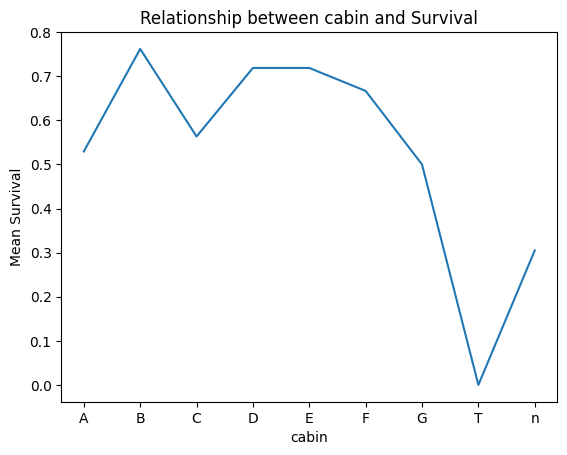

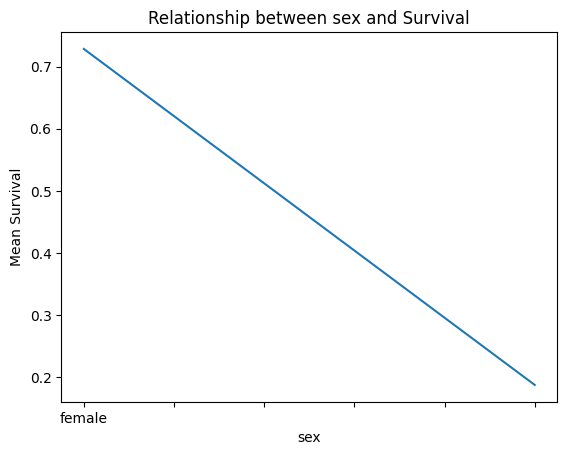

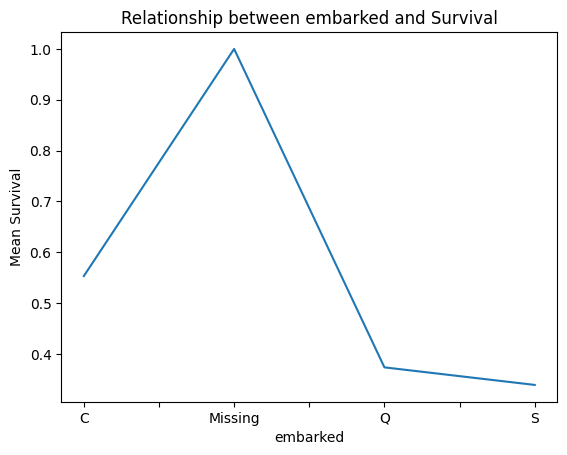

In [27]:
# let's explore the relationship of the categories with the target
for var in ["cabin", "sex", "embarked"]:
    fig = plt.figure()
    fig = y_train.groupby(X_train[var]).mean().plot()
    fig.set_title("Relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survival")
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Mean encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [28]:
# let's calculate the mean target value per category for cabin
y_train.groupby(X_train["cabin"]).mean()

cabin
A    0.529412
B    0.761905
C    0.563380
D    0.718750
E    0.718750
F    0.666667
G    0.500000
T    0.000000
n    0.304843
Name: survived, dtype: float64

In [29]:
# and now let's do the same but capturing the result in a dictionary
ordered_labels = y_train.groupby(X_train["cabin"]).mean().to_dict()
ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

In [30]:
# now, we replace the labels with the target means
X_train["cabin"] = X_train["cabin"].map(ordered_labels)
X_test["cabin"] = X_test["cabin"].map(ordered_labels)

In [31]:
# let's explore the result

X_train["cabin"].head(10)

501     0.304843
588     0.304843
402     0.304843
1193    0.304843
686     0.304843
971     0.304843
117     0.718750
540     0.304843
294     0.563380
261     0.718750
Name: cabin, dtype: float64

In [32]:
# we can turn the previous commands into 2 functions
def find_category_mappings(df, variable, target):
    return target.groupby(df[variable]).mean().to_dict()

def integer_encode(train, test, variable, ordinal_mapping):
    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [33]:
# and now we run a loop over the remaining categorical variables
for variable in ["sex", "embarked"]:
    mappings = find_category_mappings(X_train, variable, y_train)
    integer_encode(X_train, X_test, variable, mappings)

In [34]:
# let's see the result

X_train.head()

,cabin,sex,embarked
501,0.304843,0.728358,0.338957
588,0.304843,0.728358,0.338957
402,0.304843,0.728358,0.553073
1193,0.304843,0.187608,0.373494
686,0.304843,0.728358,0.373494


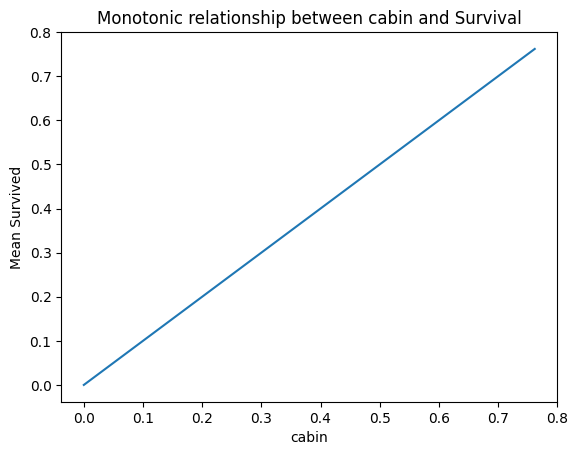

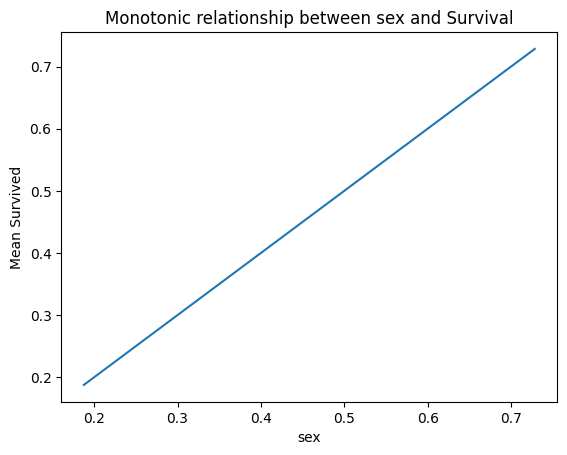

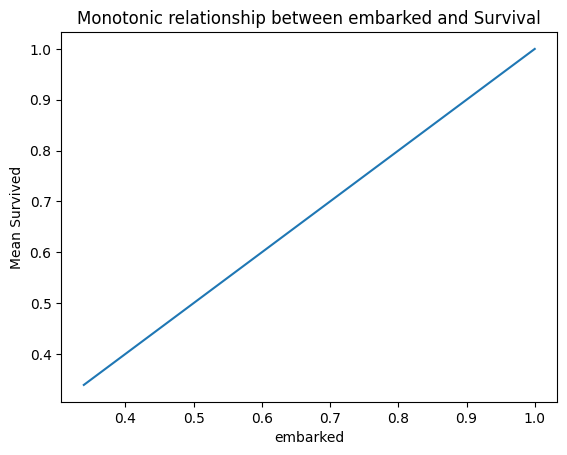

In [35]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ["cabin", "sex", "embarked"]:

    fig = plt.figure()
    fig = y_train.groupby(X_train[var]).mean().plot()
    fig.set_title("Monotonic relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survived")
    plt.show()

Mean Encoding creates linear relationships between the mean target and the categories.

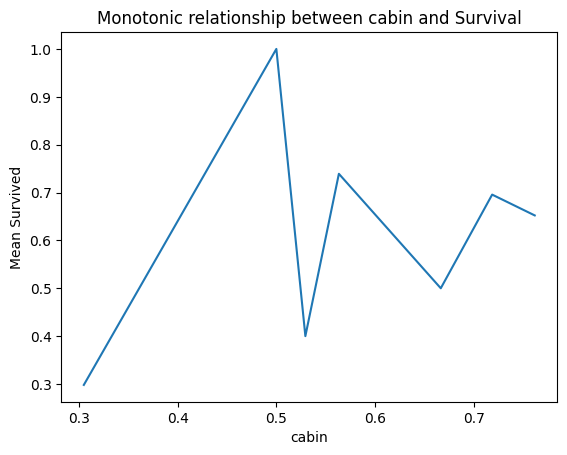

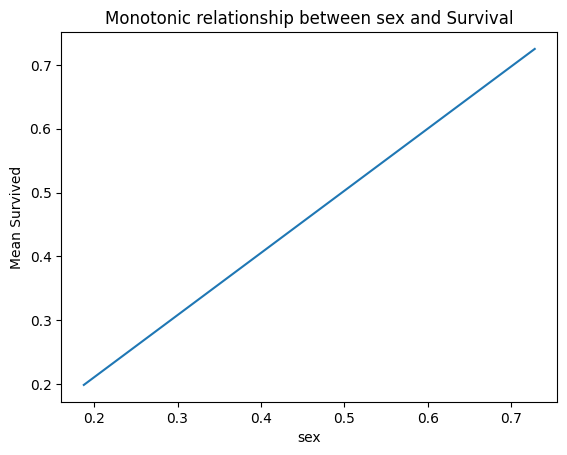

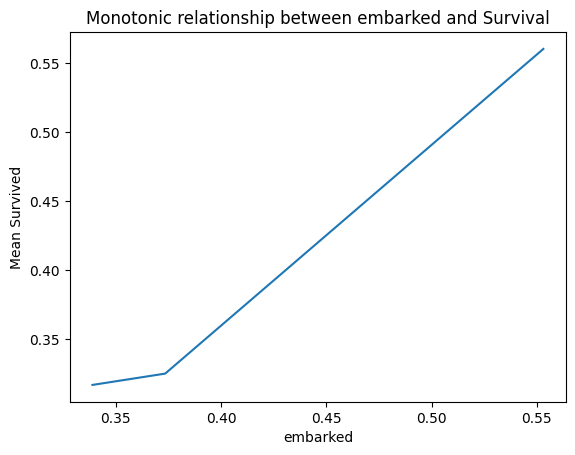

In [36]:
# let's inspect the newly created monotonic relationship
# between the variables and the target
for var in ["cabin", "sex", "embarked"]:
    fig = plt.figure()
    fig = y_test.groupby(X_test[var]).mean().plot()
    fig.set_title("Monotonic relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survived")
    plt.show()

The monotonic relationship for embarked is preserved in the test set, but not for cabin. This means that this encoding will not make cabin suitable for linear models.